In [1]:
from baseline_transformer_POS_conv import *
import copy
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())  # Renvoie True si un GPU est disponible

batch_size=16
epochs=100

True


In [3]:
# Load data using the load_data_1 function
sentences, pos_tags = load_data_1("UD_French-Sequoia/fr_sequoia-ud-train.conllu")

# Create character and tag mappings
char_counts = Counter(char for sentence in sentences for word in sentence for char in word)
char_to_ix = {char: i for i, char in enumerate(char_counts, start=2)}
char_to_ix['<PAD>'], char_to_ix['<UNK>'] = 0, 1  # Padding and unknown character

tag_counts = Counter(tag for tags in pos_tags for tag in tags)
tag_to_ix = {tag: i for i, tag in enumerate(tag_counts)}

max_word_len = max(len(word) for sentence in sentences for word in sentence)

# Now load the data in the desired format using the load_data function
train_sentences, train_pos_tags = load_data("UD_French-Sequoia/fr_sequoia-ud-train.conllu", char_to_ix, max_word_len)
validation_sentences, validation_pos_tags = load_data("UD_French-Sequoia/fr_sequoia-ud-dev.conllu", char_to_ix, max_word_len)

# Rest of your code for Dataset, DataLoader, Model initialization, etc.

# Dataset and DataLoader
dataset = POSDataset(train_sentences, train_pos_tags, tag_to_ix, max_word_len,char_to_ix)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

validation_dataset = POSDataset(validation_sentences, validation_pos_tags, tag_to_ix, max_word_len,char_to_ix)
validation_data_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)


test_sentences, test_pos_tags = load_data("UD_French-Sequoia/fr_sequoia-ud-test.conllu", char_to_ix, max_word_len)


test_dataset = POSDataset(test_sentences, test_pos_tags, tag_to_ix, max_word_len,char_to_ix)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)



In [4]:

# Model initialization
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 256
kernel_size = 3
nhead = 4
nhid = 512
nlayers = 3
tagset_size = len(tag_to_ix)

char_embedding_dim_tab = [512, 256, 128]
num_filters_tab = [256, 128]
kernel_size_tab = [2,6,12,16,20,24]
nhead_tab = [4]
nhid_tab = [512, 256, 128]
nlayers_tab = [1,2,3, 4, 5]




In [24]:
patience=5
def apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size):
        print(kernel_size)
        epochs=200

        start_time = time.time()
        best_val_accuracy = 0
        epochs_no_improve = 0
        model = POSTransformerModel(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
        loss_function = nn.CrossEntropyLoss(ignore_index=-1)
        optimizer = optim.Adam(model.parameters(), lr=0.0001)
        #Training
        for epoch in range(epochs): 
            model.train()
            model.to(device)  # Déplacer le modèle sur le GPU si disponible
            total_loss = 0
            for sentence_in, targets in data_loader:
                sentence_in, targets = sentence_in.to(device), targets.to(device)  # Déplacer les données sur le périphérique
                optimizer.zero_grad()
                tag_scores = model(sentence_in)
                loss = loss_function(tag_scores.view(-1, len(tag_to_ix)), targets.view(-1))
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            # Utiliser la fonction modifiée pour évaluer la validation loss et l'accuracy
            val_loss, val_accuracy = evaluate_model(model, validation_data_loader, loss_function,device, tag_to_ix)
            #print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_model = copy.deepcopy(model)
                #print(f"best model accuracy: {best_val_accuracy:.4f}")
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            # Arrêt précoce si aucune amélioration
            if epochs_no_improve == patience:
                print("Arrêt précoce : La loss de validation ne s'améliore plus")
                break
            #print(f"Epoch {epoch+1}, Loss: {total_loss / len(data_loader)}")
        end_time = time.time()
        elapsed_time = end_time - start_time
        final_epoch = epoch + 1  # ou epoch si vous utilisez break dans la boucle
        loss, accuracy = evaluate_model(best_model, test_data_loader, loss_function, device, tag_to_ix)
        print(f"Test Accuracy : {accuracy:.4f}")
        print(f"epoch : {final_epoch}")
        # Stocker les résultats
        result = {
            'char_embedding_dim': char_embedding_dim,
            'num_filters': num_filters,
            'kernel_size': kernel_size,
            'nhead': nhead,
            'nhid': nhid,
            'nlayers': nlayers,
            'best_val_accuracy': best_val_accuracy,
            'final_epoch': final_epoch,
            'elapsed_time': elapsed_time,
            'test_accuracy': accuracy
        }
        return result

In [6]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 1
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
import json
kernel_size_tab = [1,2,3,4,5,6]
for kernel_size in kernel_size_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    results.append(result)


with open('results1.json', 'w') as f:
    json.dump(results, f)


1


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.8863
2


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9324
3
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9345
4
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9368
5
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9357
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9387


In [9]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 1
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=1
import json
nhead_tab = [1,2,4,8]
for nhead in nhead_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)

with open('results2.json', 'w') as f:
    json.dump(results, f)


1


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.8861
[]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 1, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.8914819136522754, 'final_epoch': 87, 'elapsed_time': 118.6325831413269, 'test_accuracy': 0.886078393512261}]
1
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.8923
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 1, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.8914819136522754, 'final_epoch': 87, 'elapsed_time': 118.6325831413269, 'test_accuracy': 0.886078393512261}]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 1, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.8914819136522754, 'final_epoch': 87, 'elapsed_time': 118.6325831413269, 'test_accuracy': 0.886078393512261}, {'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 1, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_ac

In [16]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 1
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=6
import json
nhead_tab = [1,2,4,8]
for nhead in nhead_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)

with open('results3.json', 'w') as f:
    json.dump(results, f)


6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9385
epoch : 41
[]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9447685725398678, 'final_epoch': 41, 'elapsed_time': 81.97667932510376, 'test_accuracy': 0.9385016412434833}]
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9393
epoch : 36
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9447685725398678, 'final_epoch': 41, 'elapsed_time': 81.97667932510376, 'test_accuracy': 0.9385016412434833}]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 1, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9447685725398678, 'final_epoch': 41, 'elapsed_time': 81.97667932510376, 'test_accuracy': 0.9385016412434833}, {'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024,

In [27]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 1
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=6
import json
nhead=2
nhid_tab = [128, 256, 512, 1024]
for nhid in nhid_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)

with open('results3.json', 'w') as f:
    json.dump(results, f)


6


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9364
epoch : 40
[]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 128, 'nlayers': 1, 'best_val_accuracy': 0.941170750680669, 'final_epoch': 40, 'elapsed_time': 135.10968160629272, 'test_accuracy': 0.9363776790886271}]
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9396
epoch : 58
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 128, 'nlayers': 1, 'best_val_accuracy': 0.941170750680669, 'final_epoch': 40, 'elapsed_time': 135.10968160629272, 'test_accuracy': 0.9363776790886271}]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 128, 'nlayers': 1, 'best_val_accuracy': 0.941170750680669, 'final_epoch': 40, 'elapsed_time': 135.10968160629272, 'test_accuracy': 0.9363776790886271}, {'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 256, 'nlay

In [29]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 1
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=6
import json
nhead=2
nhid=1024
char_embedding_dim_tab = [32,64,128, 256, 512, 1024]
for char_embedding_dim in char_embedding_dim_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)

with open('results3.json', 'w') as f:
    json.dump(results, f)

6


C:\Users\victo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9348
epoch : 75
[]
[{'char_embedding_dim': 32, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9396149358226371, 'final_epoch': 75, 'elapsed_time': 116.7148985862732, 'test_accuracy': 0.9348329793396408}]
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9363
epoch : 58
[{'char_embedding_dim': 32, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9396149358226371, 'final_epoch': 75, 'elapsed_time': 116.7148985862732, 'test_accuracy': 0.9348329793396408}]
[{'char_embedding_dim': 32, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9396149358226371, 'final_epoch': 75, 'elapsed_time': 116.7148985862732, 'test_accuracy': 0.9348329793396408}, {'char_embedding_dim': 64, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlay

In [25]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 1024
nhead = 2
nhid = 1024
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=6
import json
nlayers_tab = [1,2,3,4,5,6]
for nlayers in nlayers_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)
with open('results4.json', 'w') as f:
    json.dump(results, f)

6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9427
epoch : 34
[]
[{'char_embedding_dim': 512, 'num_filters': 1024, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9471022948269155, 'final_epoch': 34, 'elapsed_time': 336.6894974708557, 'test_accuracy': 0.942653021818884}]
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9415
epoch : 19
[{'char_embedding_dim': 512, 'num_filters': 1024, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9471022948269155, 'final_epoch': 34, 'elapsed_time': 336.6894974708557, 'test_accuracy': 0.942653021818884}]
[{'char_embedding_dim': 512, 'num_filters': 1024, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9471022948269155, 'final_epoch': 34, 'elapsed_time': 336.6894974708557, 'test_accuracy': 0.942653021818884}, {'char_embedding_dim': 512, 'num_filters': 1024, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024

In [20]:
num_chars = len(char_to_ix)
char_embedding_dim = 512
num_filters = 128
nhead = 2
nhid = 1024
nlayers = 1
tagset_size = len(tag_to_ix)
patience = 5
results = []
kernel_size=6
import json
number_filters_tab = [128,256, 512, 1024, 1536, 2048]
for num_filters in number_filters_tab:
    result=apprentissage(num_chars, char_embedding_dim, num_filters, kernel_size, nhead, nhid, nlayers, tagset_size)
    print(results)
    results.append(result)
    print(results)
with open('results5.json', 'w') as f:
    json.dump(results, f)

6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9391
epoch : 32
[]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9402956048230261, 'final_epoch': 32, 'elapsed_time': 91.16052889823914, 'test_accuracy': 0.9390809036493531}]
6
Arrêt précoce : La loss de validation ne s'améliore plus
Test Accuracy : 0.9399
epoch : 26
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9402956048230261, 'final_epoch': 32, 'elapsed_time': 91.16052889823914, 'test_accuracy': 0.9390809036493531}]
[{'char_embedding_dim': 512, 'num_filters': 128, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024, 'nlayers': 1, 'best_val_accuracy': 0.9402956048230261, 'final_epoch': 32, 'elapsed_time': 91.16052889823914, 'test_accuracy': 0.9390809036493531}, {'char_embedding_dim': 512, 'num_filters': 256, 'kernel_size': 6, 'nhead': 2, 'nhid': 1024,

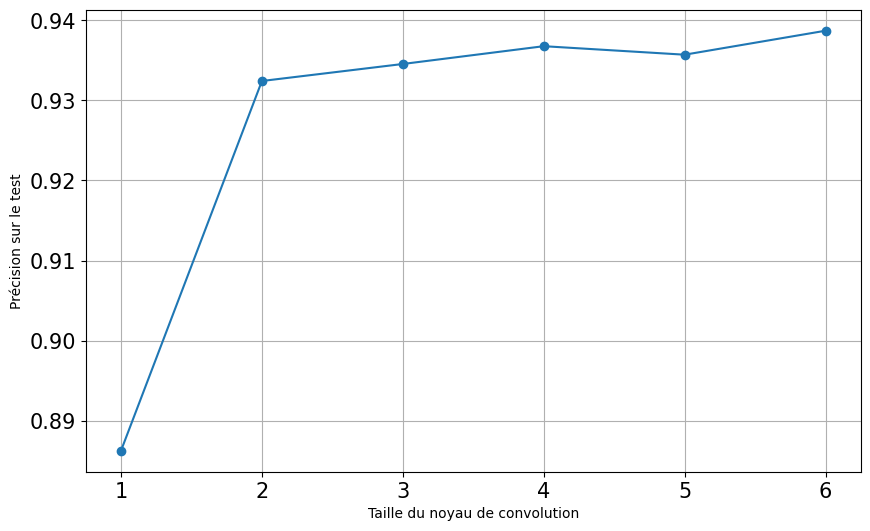

In [8]:
import matplotlib.pyplot as plt
import json
import matplotlib as mpl

# Setting global parameters for matplotlib
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15

# JSON data
with open('results1.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting kernel_size and test_accuracy
kernel_sizes = [item['kernel_size'] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, test_accuracies, marker='o')
#plt.title('Test Accuracy vs Kernel Size')
plt.xlabel('Taille du noyau de convolution')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/kernel_size.png')
plt.show()


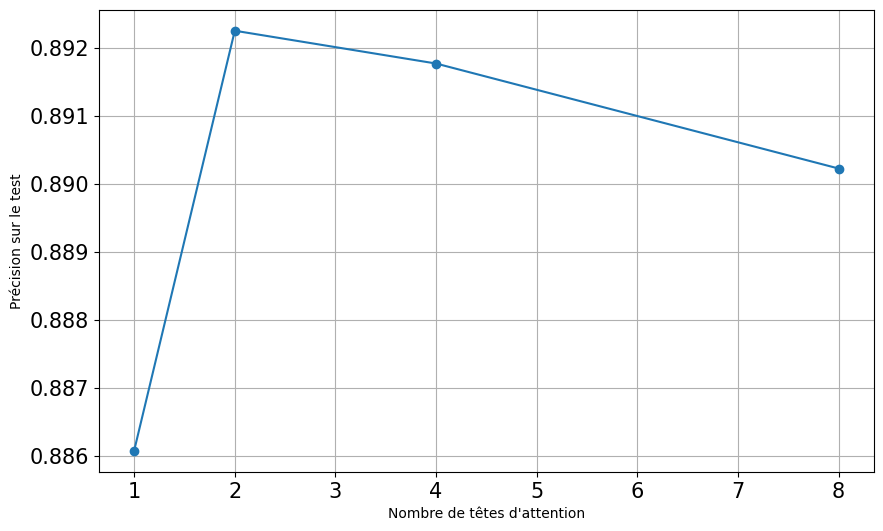

In [10]:
# JSON data
with open('results2.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting kernel_size and test_accuracy
kernel_sizes = [item['nhead'] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, test_accuracies, marker='o')
#plt.title('Test Accuracy vs Kernel Size')
plt.xlabel('Nombre de têtes d\'attention')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/nheads.png')
plt.show()

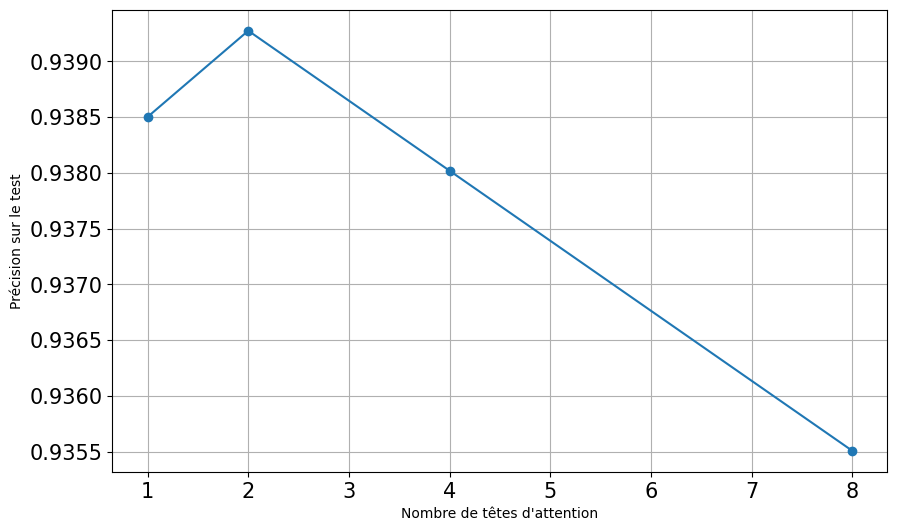

In [17]:
# JSON data
with open('results3.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting kernel_size and test_accuracy
kernel_sizes = [item['nhead'] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, test_accuracies, marker='o')
#plt.title('Test Accuracy vs Kernel Size')
plt.xlabel('Nombre de têtes d\'attention')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/nheads_kernel_size6.png')
plt.show()

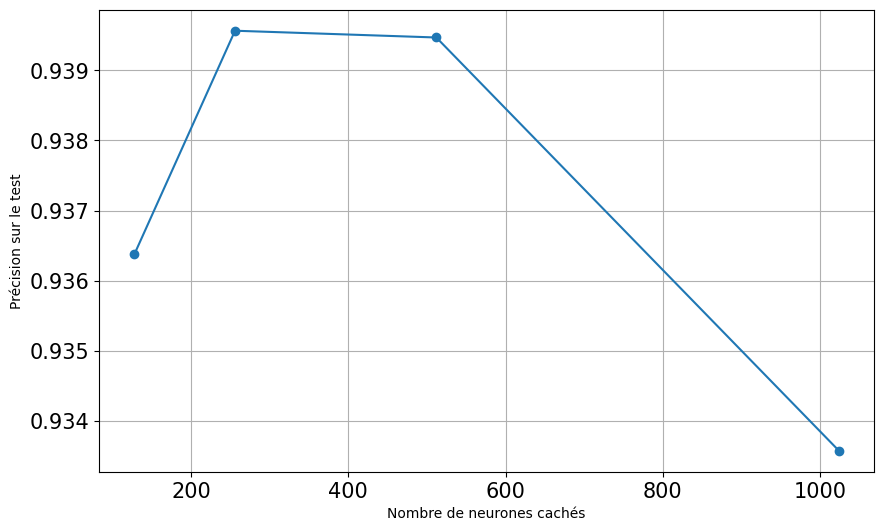

In [28]:
# JSON data
with open('results3.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting kernel_size and test_accuracy
kernel_sizes = [item[''] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(kernel_sizes, test_accuracies, marker='o')
#plt.title('Test Accuracy vs Kernel Size')
plt.xlabel('Nombre de neurones cachés')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/nhid.png')
plt.show()

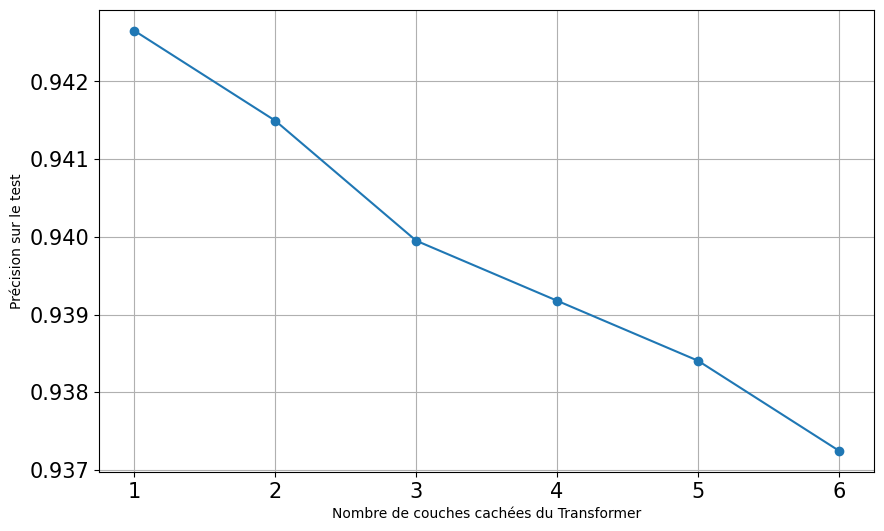

In [26]:
import json
import matplotlib.pyplot as plt

# JSON data loading and plotting
with open('results4.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting nhid (size of hidden layers in Transformer) and test_accuracy
nhid_values = [item['nlayers'] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nhid_values, test_accuracies, marker='o')
plt.xlabel('Nombre de couches cachées du Transformer')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/transformer_nlayers.png')
plt.show()


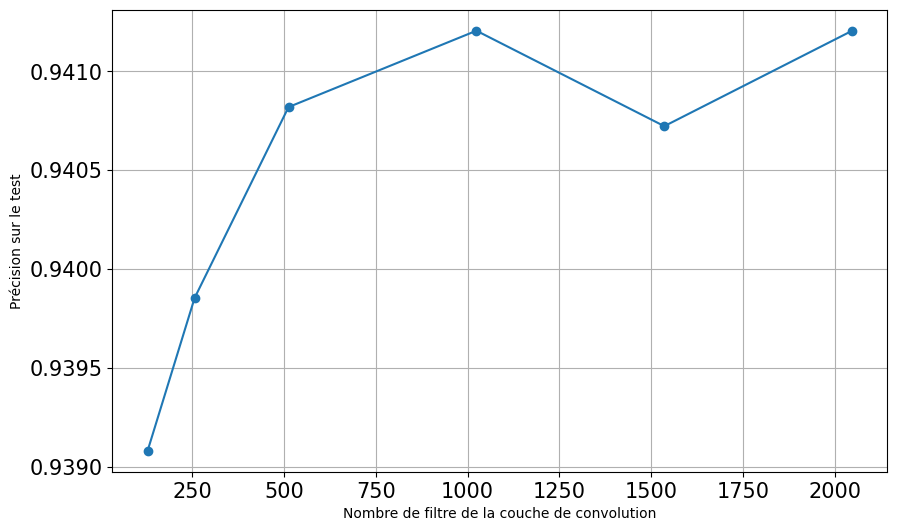

In [21]:
import json
import matplotlib.pyplot as plt

# JSON data loading and plotting
with open('results5.json') as f:
    data_json = f.read()

# Loading the JSON data
data = json.loads(data_json)

# Extracting nhid (size of hidden layers in Transformer) and test_accuracy
nhid_values = [item['num_filters'] for item in data]
test_accuracies = [item['test_accuracy'] for item in data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nhid_values, test_accuracies, marker='o')
plt.xlabel('Nombre de filtre de la couche de convolution')
plt.ylabel('Précision sur le test')
plt.grid(True)
plt.savefig('experiences_images/transformer_nfilters.png')
plt.show()